In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange

In [2]:
experiments = []

In [24]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Red base (modificar en el forward también)
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Red grande (modificar en el forward también)
        # self.fc1 = nn.Linear(32 * 32 * 3, 480)
        # self.fc2 = nn.Linear(480, 240)
        # self.fc3 = nn.Linear(240, 120)
        # self.fc4 = nn.Linear(120, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # Red base
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # Red grande
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = self.fc4(x)

        return x

In [25]:
# Sin normalización de la entrada
transform = transforms.ToTensor()
# Con normalización de la entrada
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [26]:
net = Net()
criterion = nn.CrossEntropyLoss()

# Optimizar con SGD
optimizer = optim.SGD(net.parameters(), lr=0.001)

# Optimizar con Adam
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)

cuda:0


Net(
  (fc1): Linear(in_features=3072, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=120, bias=True)
  (fc4): Linear(in_features=120, out_features=10, bias=True)
)

In [28]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
trainning_losses = []
val_losses = []
val_indices = []
last_train_idx  = 0
for epoch in trange(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trainning_losses.append(loss.item())
        running_loss += loss.item() * batch_size
        last_train_idx += 1

    running_val_loss = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_val_loss += loss.item() * batch_size

    running_loss = running_loss / len(trainset)
    running_val_loss = running_val_loss / len(valset)
    val_losses.append(running_val_loss)
    val_indices.append(last_train_idx)

    print(f'Ep. {epoch + 1}. Train Loss: {running_loss :.3f} Val Loss: {running_val_loss :.3f}')

experiments.append((trainning_losses, val_indices, val_losses))

  0%|          | 0/10 [00:00<?, ?it/s]

Ep. 1. Train Loss: 1.712 Val Loss: 1.561
Ep. 2. Train Loss: 1.461 Val Loss: 1.453
Ep. 3. Train Loss: 1.340 Val Loss: 1.397
Ep. 4. Train Loss: 1.239 Val Loss: 1.363
Ep. 5. Train Loss: 1.162 Val Loss: 1.348
Ep. 6. Train Loss: 1.082 Val Loss: 1.362
Ep. 7. Train Loss: 1.006 Val Loss: 1.337
Ep. 8. Train Loss: 0.938 Val Loss: 1.410
Ep. 9. Train Loss: 0.866 Val Loss: 1.394
Ep. 10. Train Loss: 0.806 Val Loss: 1.463


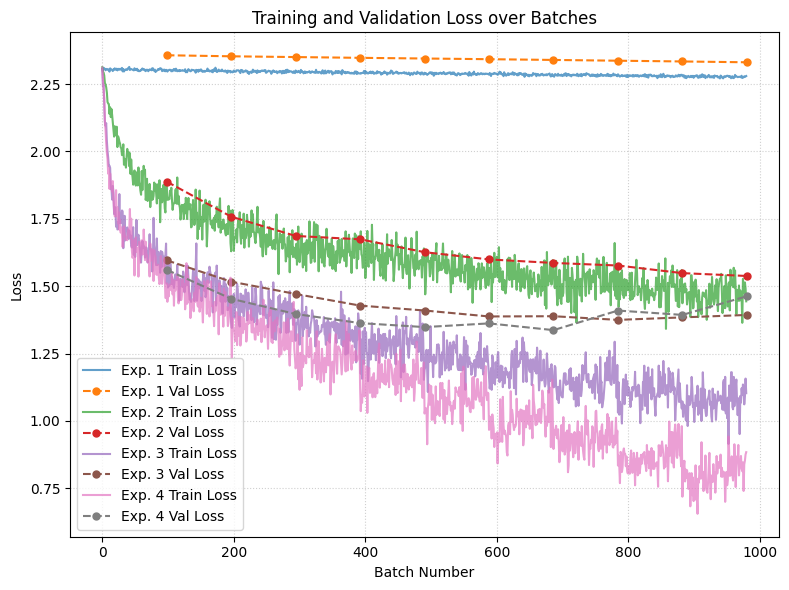

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for exp_idx, (train_losses, val_indices, val_losses) in enumerate(experiments, 1):
    plt.plot(train_losses, label=f'Exp. {exp_idx} Train Loss', alpha=0.7)
    plt.plot(val_indices, val_losses, label=f'Exp. {exp_idx} Val Loss', linestyle='--', marker='o', markersize=5)

plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Batches')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()
